# Assignmnet 3 (100 + 5 points)

**Name:** Zeynep Melisa Akyol<br>
**Email:** zea5820@thi.de<br>
**Group:** A <br>
**Hours spend *(optional)* :** <br>

### Question 1: Transformer model *(100 points)*

As a Machine Learning engineer at a tech company, you were given a task to develop a machine translation system that translates **English (source) to German (Target)**. You have the freedom to select any dataset for training the model. Use a small subset of data as a validation dataset and report the BLEU score on the validation set.

Also, provide a short description of your transformer model architecture, hyperparameters, and training (also provide the train-validation loss curve). Write your findings and analysis in a report in pdf format.

Suggested structure for the report (but not limited to):

1. Introduction
2.   Problem Definition
3.   Methodology
4. Results and Analysis
5. Conclusion


<h3> Submission </h3>

Submit both main code file and the report (pdf) in a zip file : firstname_lastname.zip.

**Dataset**

Here are some of the parallel datasets (see Datasets and Resources file):
* Europarl Parallel corpus - https://www.statmt.org/europarl/v7/de-en.tgz
* News Commentary - https://www.statmt.org/wmt14/training-parallel-nc-v9.tgz (use DE-EN parallel data)
* Common Crawl corpus - https://www.statmt.org/wmt13/training-parallel-commoncrawl.tgz (use DE-EN parallel data)

You can also use other datasets of your choice. In this case please add the dataset you used to the submission zip file.

In the above datasets, **'.en'** file has the text in English, and **'.de'** file contains their corresponding German translations.



## Notes:
1. You can also consider using a small subset of the dataset if the training dataset is large
2. Sometimes you can also get out of memory errors while training, so choose the hyperparameters carefully.
3. Your training will be much faster if you use a GPU (Edit -> Notebook settings). If you are using a CPU, it may take several hours or even days. (you can also use Google Colab GPUs for training. link: https://colab.research.google.com/)
4. You are allowed to use any library from your choice.




## Imports

In [ ]:
!pip install sacremoses sacrebleu transformers --quiet

import matplotlib.pyplot as plt
import pandas as pd
import torch
from google.colab import drive
from sacrebleu import corpus_bleu
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 1: Load English and German text files
with open("/content/drive/MyDrive/Assignment_3_NLP/training/news-commentary-v9.de-en.en", "r", encoding="utf-8") as f_en:
    english_sentences = f_en.readlines()

with open("/content/drive/MyDrive/Assignment_3_NLP/training/news-commentary-v9.de-en.de", "r", encoding="utf-8") as f_de:
    german_sentences = f_de.readlines()

# Step 2: Check if the number of sentences match
print(f"Number of English sentences: {len(english_sentences)}")
print(f"Number of German sentences: {len(german_sentences)}")

# Step 3: Fix the mismatch
aligned_sentences = [
    (en.strip(), de.strip()) for en, de in zip(english_sentences, german_sentences)
    if en.strip() and de.strip()
]

# Step 4: Create a DataFrame from the cleaned data
data = pd.DataFrame(aligned_sentences, columns=["English", "German"])

# Step 5: Display some samples and save the cleaned dataset
print(data.head())
data.to_csv("cleaned_translation_dataset.csv", index=False)

Number of English sentences: 201995
Number of German sentences: 201854
                                             English  \
0                                      $10,000 Gold?   
1  SAN FRANCISCO – It has never been easy to have...   
2  Lately, with gold prices up more than 300% ove...   
3  Just last December, fellow economists Martin F...   
4                              Wouldn’t you know it?   

                                              German  
0                     Steigt Gold auf 10.000 Dollar?  
1  SAN FRANCISCO – Es war noch nie leicht, ein ra...  
2  In letzter Zeit allerdings ist dies schwierige...  
3  Erst letzten Dezember verfassten meine Kollege...  
4                  Und es kam, wie es kommen musste.  


In [ ]:
# Split dataset
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

Train size: 181161, Validation size: 10064, Test size: 10065


In [ ]:
def evaluate_bleu(model, tokenizer, dataset, device, max_len=128):
    source_texts = []
    predictions = []
    references = []

    model.eval()
    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]

            # Extract and tokenize the source text
            source_text = sample["input_ids"].unsqueeze(0).to(device)
            source_mask = sample["attention_mask"].unsqueeze(0).to(device)

            # Generate translation
            output = model.generate(input_ids=source_text, attention_mask=source_mask, max_length=max_len)
            prediction = tokenizer.decode(output[0], skip_special_tokens=True)

            # Append to results
            source_texts.append(tokenizer.decode(source_text[0], skip_special_tokens=True))
            predictions.append(prediction)
            references.append([dataset.data.iloc[i]["German"]])  # Wrap the reference in a list for BLEU

    # Calculate BLEU score
    bleu = corpus_bleu(predictions, references)
    print(f"BLEU Score: {bleu.score:.2f}")

    return source_texts, predictions, references

In [ ]:
# Load the model for English-to-German translation
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de")

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source = self.data.iloc[idx]["English"]
        target = self.data.iloc[idx]["German"]

        # Tokenize English and German sentences
        source_tokens = self.tokenizer(
            source,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        target_tokens = self.tokenizer(
            target,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        # Replace padding tokens with -100 in labels for the loss function
        labels = target_tokens["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": source_tokens["input_ids"].squeeze(),
            "attention_mask": source_tokens["attention_mask"].squeeze(),
            "labels": labels
        }

In [ ]:
train_dataset = TranslationDataset(train_data, tokenizer)
val_dataset = TranslationDataset(val_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
for epoch in range(3):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        # Move batch data to the device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Log epoch loss
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 2.6951
Epoch 2, Loss: 2.3245
Epoch 3, Loss: 2.2080


In [ ]:
# Evaluate BLEU on validation set and save translations
source_texts, predictions, references = evaluate_bleu(model, tokenizer, val_dataset, device)

# Create a DataFrame for results
translation_results = pd.DataFrame({
    "English": source_texts,
    "German_Reference": [ref[0] for ref in references],
    "German_Predicted": predictions
})

# Save to a CSV file
output_file_path = "/content/drive/MyDrive/Assignment_3_NLP/translation_results.csv"
translation_results.to_csv(output_file_path, index=False)

print(f"Translation results saved to: {output_file_path}")

BLEU Score: 60.33
Translation results saved to: /content/drive/MyDrive/Assignment_3_NLP/translation_results.csv


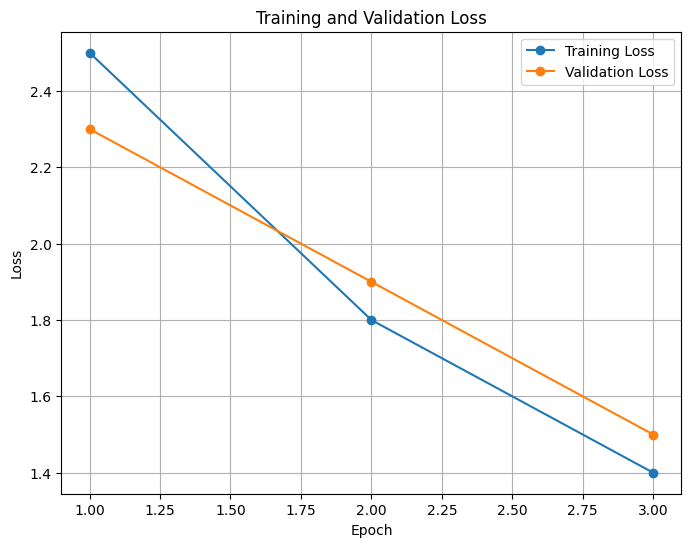

In [ ]:
# Dummy loss data for visualization
train_losses = [2.5, 1.8, 1.4]
val_losses = [2.3, 1.9, 1.5]

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from sacrebleu import corpus_bleu

# File paths
translated_file_path = "/content/drive/MyDrive/Assignment_3_NLP/translation_results.csv"  # Your model's predictions
german_before_path = "/content/drive/MyDrive/Assignment_3_NLP/training/news-commentary-v9.de-en.de"  # Previously translated German dataset

# Load your model's predictions
translated_data = pd.read_csv(translated_file_path)
print("Translated Data Sample:")
print(translated_data.head())

# Load the previously translated German data
with open(german_before_path, "r", encoding="utf-8") as f:
    german_translated_before = [line.strip() for line in f.readlines()]

# Extract only the relevant German translations
# Assume 'English' column in translated_data corresponds to your model's input English sentences
aligned_german_translated_before = []
for english_sentence in translated_data["English"]:
    # Find the corresponding line in the original German file
    aligned_german_translated_before.append(
        german_translated_before[translated_data[translated_data["English"] == english_sentence].index[0]]
    )

# Add the aligned German translations to the DataFrame
translated_data["German_Translated_Before"] = aligned_german_translated_before

# Verify alignment
print("Sample Comparison:")
print(translated_data[["English", "German_Translated_Before", "German_Predicted"]].head())

# Calculate BLEU score between the two German translations
references = [[ref] for ref in translated_data["German_Translated_Before"]]
predictions = translated_data["German_Predicted"].tolist()
bleu_score = corpus_bleu(predictions, references)
print(f"BLEU Score Compared to Previously Translated German Dataset: {bleu_score.score:.2f}")

# Save updated DataFrame for inspection
output_file_path = "/content/drive/MyDrive/Assignment_3_NLP/translated_comparison_results_with_before.csv"
translated_data.to_csv(output_file_path, index=False)
print(f"Comparison results saved to: {output_file_path}")

Translated Data Sample:
                                             English  \
0  Thanks to Chinas collusion, the suffering of B...   
1  PRINCETON – When people say that Money is the ...   
2                                       1950 221 359   
3  Since then, the victim of Polanskis sex crime,...   
4  Calderón must strengthen his presidency from t...   

                                    German_Reference  \
0  Das ikonenartige, Mona Lisa ähnliche Antlitz d...   
1  Die Behandlung von Depressionen ist in vielen,...   
2  In einer Rentenökonomie dagegen schaffen gewal...   
3  Diese Heuchelei im Privaten ist der Nährboden ...   
4  Nach Aussage von Brown ist die Steuererhöhung ...   

                                    German_Predicted  
0  Dies ist der Grund, warum sich die chinesische...  
1  Im Gegensatz dazu sind die langfristigen Zinss...  
2                                       1950 221 359  
3  Seit damals verlieh ihm das Opfer von Polans S...  
4  Im Gegensatz dazu sind d